# 5-Fold Cross-Validation for InceptionTime

While there is a [tendency in the AI community](https://www.fast.ai/2017/11/13/validation-sets/), to dismiss cross-validation as overkill for deep learning models, we have the feeling it is a valueable metric for our case, especially since we can't shuffle the training/validation set (to ensure clearn speration).

So we perform a 5-fold cross validation and check for precision, recall and f1-score.

In [2]:
import tsai
from tsai.all import *
import pandas as pd
import scipy
from sklearn.metrics import roc_auc_score, classification_report

from winkie import ts_prep

# Load and perpare data

In [4]:
df = pd.read_hdf("merged_20210405.h5")
df.loc[(df['behavior'] == "back_preening") | (df['behavior'] == "front_preening"), 'behavior'] = "preening"
df.loc[(df['behavior'] == "standing_shaking") | (df['behavior'] == "scratch_with_feet"), 'behavior'] = "standing"
df.loc[(df['behavior'] == "body_pump") | (df['behavior'] == "feather_clapping"), 'behavior'] = "fluffing"
df = df[(df['behavior'] != "not_defined")]


# 16 frames sliding window

In [5]:
features = [('head', 'x'), ('head', 'y'), 
            ('tail', 'x'), ('tail', 'y'),  
            
            ('left_neck', 'x'), ('left_neck', 'y'), 
            ('right_neck', 'x'), ('right_neck', 'y'), 
            
            ('left_up_wing', 'x'), ('left_up_wing', 'y'),
            ('left_middle_wing', 'x'), ('left_middle_wing', 'y'),
            ('left_down_wing', 'x'), ('left_down_wing', 'y'),
            
            ('right_up_wing', 'x'), ('right_up_wing', 'y'),
            ('right_middle_wing', 'x'), ('right_middle_wing', 'y'),
            ('right_down_wing', 'x'), ('right_down_wing', 'y'),
]
def y_func(o): 
    return scipy.stats.mode(o, axis=1).mode.ravel()

X, y = SlidingWindow(16, get_x=features, get_y='behavior', y_func=y_func)(df)

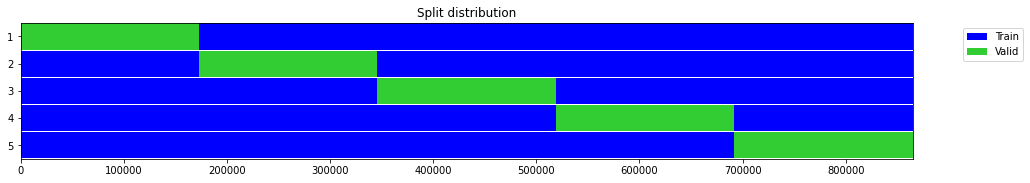

In [15]:
splits = get_splits(y, n_splits=5, shuffle=False, stratify=True, check_splits=True)
tfms  = [None, [Categorize()]]

In [85]:
def train_and_evaluate_it(X, y, splits, bs, lr, epochs):
    tfms  = [None, [Categorize()]]
    dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
    dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=bs, batch_tfms=[TSStandardize()], num_workers=0)
    
    model = InceptionTime(dls.vars, dls.c)
    learn = Learner(dls, model, metrics=accuracy)
    #lr_min,lr_steep = learn.lr_find(suggestions=True)
    #print(f"Minimum/10: {lr_min}, steepest point: {lr_steep}")
    #print(f"Using LR: {lr}")
    learn.fit_one_cycle(epochs, lr_max=lr)
    learn.recorder.plot_metrics()
    
    dls = learn.dls
    valid_dl = dls.valid
    valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)
    cat_ac = (valid_targets == valid_preds).float().mean()
    print(cat_ac)
    print(roc_auc_score(valid_targets, valid_probas, multi_class='ovo', average='macro'))
    print(classification_report(valid_preds, valid_targets))
    interp = ClassificationInterpretation.from_learner(learn)
    interp.plot_confusion_matrix(normalize=True, figsize=(10, 10))
    interp.plot_confusion_matrix(figsize=(10, 10))

In [62]:
for i, s in enumerate(splits):
    print(f'===================== Fold {i} ============================')
    train_and_evaluate_it(X, y, s, 512, 0.001, 1)

===================== Fold 0 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.083362,0.598614,0.835905,01:06


TensorCategory(0.8359)
0.8798415186416432
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     92519
           1       0.57      0.14      0.22      1184
           2       0.33      0.27      0.30       833
           3       0.52      0.49      0.50      4281
           4       0.75      0.89      0.81     58160
           5       0.60      0.41      0.49       231
           6       0.41      0.10      0.16     15899

    accuracy                           0.84    173107
   macro avg       0.59      0.46      0.49    173107
weighted avg       0.81      0.84      0.81    173107

===================== Fold 1 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.075768,0.613193,0.811238,01:05


TensorCategory(0.8112)
0.9146840183396536
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     68657
           1       0.82      0.18      0.29     14466
           2       0.30      0.25      0.28      2106
           3       0.78      0.74      0.76     22198
           4       0.81      0.90      0.85     57047
           5       0.55      0.64      0.59      1108
           6       0.37      0.19      0.25      7525

    accuracy                           0.81    173107
   macro avg       0.64      0.55      0.56    173107
weighted avg       0.80      0.81      0.78    173107

===================== Fold 2 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.078540,1.183794,0.666748,01:06


TensorCategory(0.6667)
0.8647206202193035
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     64219
           1       0.72      0.62      0.67      8259
           2       0.19      0.16      0.17      3695
           3       0.79      0.34      0.47     50666
           4       0.37      0.82      0.51     30906
           5       0.60      0.63      0.61      2591
           6       0.52      0.17      0.25     12770

    accuracy                           0.67    173106
   macro avg       0.59      0.53      0.52    173106
weighted avg       0.74      0.67      0.66    173106

===================== Fold 3 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.075500,0.400697,0.884718,01:06


TensorCategory(0.8847)
0.9157669459214794
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     53088
           1       0.71      0.80      0.75      4775
           2       0.45      0.25      0.33      2951
           3       0.49      0.57      0.53      8092
           4       0.93      0.91      0.92     94353
           5       0.50      0.58      0.54       597
           6       0.51      0.56      0.54      9250

    accuracy                           0.88    173106
   macro avg       0.66      0.67      0.66    173106
weighted avg       0.89      0.88      0.89    173106

===================== Fold 4 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.083286,0.330508,0.908680,01:06


TensorCategory(0.9087)
0.9373981747631687
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     65251
           1       0.74      0.87      0.80     10062
           2       0.49      0.45      0.47      1755
           3       0.77      0.74      0.75      9153
           4       0.95      0.91      0.93     79614
           5       0.57      0.62      0.59      1590
           6       0.47      0.53      0.50      5681

    accuracy                           0.91    173106
   macro avg       0.71      0.73      0.72    173106
weighted avg       0.91      0.91      0.91    173106



In [63]:
for i, s in enumerate(splits):
    print(f'===================== Fold {i} ============================')
    train_and_evaluate_it(X, y, s, 512, 0.001, 5)

===================== Fold 0 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.153711,0.512022,0.901055,01:06
1,0.081928,0.736346,0.843351,01:06
2,0.042729,0.806173,0.866152,01:06
3,0.020116,0.806822,0.889080,01:06
4,0.011205,0.941020,0.862484,01:06


TensorCategory(0.8625)
0.8752962957923319
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     90415
           1       0.64      0.30      0.41       607
           2       0.23      0.48      0.32       335
           3       0.54      0.38      0.45      5617
           4       0.82      0.88      0.85     64726
           5       0.72      0.49      0.58       231
           6       0.36      0.12      0.18     11176

    accuracy                           0.86    173107
   macro avg       0.61      0.52      0.53    173107
weighted avg       0.84      0.86      0.85    173107

===================== Fold 1 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.146147,0.777451,0.760922,01:06
1,0.078187,0.578491,0.827350,01:06
2,0.045386,0.711025,0.818026,01:06
3,0.020801,0.943002,0.792845,01:06
4,0.012628,1.014106,0.787166,01:07


TensorCategory(0.7872)
0.9127679494856664
              precision    recall  f1-score   support

           0       0.82      0.98      0.89     65683
           1       0.80      0.13      0.22     19033
           2       0.43      0.56      0.49      1325
           3       0.76      0.73      0.74     21720
           4       0.80      0.91      0.85     55408
           5       0.53      0.68      0.60      1001
           6       0.39      0.17      0.23      8937

    accuracy                           0.79    173107
   macro avg       0.65      0.60      0.58    173107
weighted avg       0.78      0.79      0.75    173107

===================== Fold 2 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.142419,0.641515,0.806852,01:07
1,0.080638,0.663227,0.806252,01:07
2,0.041184,0.916363,0.779967,01:07
3,0.020608,1.009530,0.748692,01:07
4,0.011199,1.056984,0.763388,01:07


TensorCategory(0.7634)
0.8786005034364467
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     62663
           1       0.68      0.58      0.62      8441
           2       0.23      0.16      0.18      4463
           3       0.76      0.52      0.62     31503
           4       0.65      0.86      0.74     52690
           5       0.58      0.59      0.58      2658
           6       0.43      0.17      0.24     10688

    accuracy                           0.76    173106
   macro avg       0.61      0.55      0.57    173106
weighted avg       0.75      0.76      0.75    173106

===================== Fold 3 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.139480,0.409396,0.872385,01:07
1,0.078283,0.503437,0.880073,01:07
2,0.042332,0.581368,0.881408,01:07
3,0.019643,0.648721,0.869207,01:06
4,0.011967,0.652899,0.873216,01:06


TensorCategory(0.8732)
0.8982101803441771
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     52532
           1       0.68      0.67      0.68      5422
           2       0.45      0.20      0.28      3724
           3       0.47      0.62      0.53      7023
           4       0.91      0.92      0.91     91989
           5       0.44      0.35      0.39       868
           6       0.58      0.51      0.55     11548

    accuracy                           0.87    173106
   macro avg       0.64      0.61      0.62    173106
weighted avg       0.87      0.87      0.87    173106

===================== Fold 4 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.144126,0.389740,0.890356,01:06
1,0.075548,0.433466,0.886081,01:06
2,0.043086,0.461284,0.899957,01:07
3,0.018484,0.514221,0.905208,01:06
4,0.011098,0.541949,0.900939,01:07


TensorCategory(0.9009)
0.9307212113191674
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     65493
           1       0.70      0.82      0.76     10031
           2       0.51      0.43      0.47      1891
           3       0.75      0.68      0.71      9724
           4       0.93      0.92      0.93     77374
           5       0.60      0.50      0.55      2117
           6       0.48      0.47      0.48      6476

    accuracy                           0.90    173106
   macro avg       0.71      0.69      0.70    173106
weighted avg       0.90      0.90      0.90    173106



In [64]:
for i, s in enumerate(splits):
    print(f'===================== Fold {i} ============================')
    train_and_evaluate_it(X, y, s, 256, 0.001, 5)

===================== Fold 0 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.154720,0.570985,0.888682,02:02
1,0.085294,0.627420,0.905694,02:02
2,0.044381,0.738537,0.900160,02:02
3,0.021063,0.959695,0.860254,02:02
4,0.015418,0.991055,0.858325,02:02


TensorCategory(0.8583)
0.8861691674728748
              precision    recall  f1-score   support

           0       0.93      0.96      0.95     92145
           1       0.60      0.23      0.33       738
           2       0.46      0.29      0.35      1111
           3       0.44      0.25      0.32      7099
           4       0.81      0.88      0.84     64463
           5       0.66      0.21      0.32       495
           6       0.35      0.19      0.25      7056

    accuracy                           0.86    173107
   macro avg       0.61      0.43      0.48    173107
weighted avg       0.84      0.86      0.85    173107

===================== Fold 1 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.148174,0.530480,0.850590,02:02
1,0.084568,0.569908,0.856615,02:02
2,0.044635,0.640914,0.861144,02:02
3,0.023786,0.715953,0.865476,02:02
4,0.014570,0.786890,0.864581,02:01


TensorCategory(0.8646)
0.909498247733243
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     79098
           1       0.79      0.41      0.54      5958
           2       0.40      0.48      0.44      1451
           3       0.78      0.76      0.77     21626
           4       0.81      0.91      0.86     56021
           5       0.52      0.53      0.52      1269
           6       0.33      0.16      0.22      7684

    accuracy                           0.86    173107
   macro avg       0.66      0.60      0.62    173107
weighted avg       0.85      0.86      0.86    173107

===================== Fold 2 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.147354,0.902411,0.688318,02:01
1,0.079630,1.476566,0.669867,02:01
2,0.047830,0.862973,0.788367,02:01
3,0.020859,1.449636,0.728554,02:02
4,0.013534,1.730907,0.705071,02:01


TensorCategory(0.7051)
0.8752843821355243
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     64492
           1       0.68      0.62      0.65      7894
           2       0.25      0.14      0.18      5589
           3       0.76      0.38      0.50     43375
           4       0.47      0.86      0.61     38467
           5       0.61      0.56      0.59      2962
           6       0.53      0.21      0.30     10327

    accuracy                           0.71    173106
   macro avg       0.61      0.53      0.54    173106
weighted avg       0.74      0.71      0.69    173106

===================== Fold 3 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.144898,0.381229,0.880039,02:01
1,0.076649,0.461517,0.890489,02:01
2,0.044137,0.480147,0.894192,02:02
3,0.023720,0.561247,0.892817,02:01
4,0.013657,0.578626,0.893464,02:01


TensorCategory(0.8935)
0.9068449240395932
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     52885
           1       0.72      0.76      0.74      5054
           2       0.53      0.32      0.40      2755
           3       0.48      0.73      0.58      6196
           4       0.94      0.92      0.93     94753
           5       0.54      0.48      0.51       768
           6       0.56      0.54      0.55     10695

    accuracy                           0.89    173106
   macro avg       0.68      0.68      0.67    173106
weighted avg       0.90      0.89      0.89    173106

===================== Fold 4 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.155150,0.376662,0.893944,02:01
1,0.080655,0.482531,0.855851,02:01
2,0.046104,0.453284,0.896329,02:02
3,0.019643,0.526946,0.897883,02:01
4,0.015767,0.554946,0.898247,02:01


TensorCategory(0.8982)
0.9278645543832317
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     65583
           1       0.68      0.88      0.77      9158
           2       0.51      0.42      0.46      1944
           3       0.75      0.64      0.69     10339
           4       0.93      0.92      0.92     77265
           5       0.61      0.53      0.57      2037
           6       0.52      0.49      0.51      6780

    accuracy                           0.90    173106
   macro avg       0.71      0.69      0.70    173106
weighted avg       0.90      0.90      0.90    173106



In [65]:
for i, s in enumerate(splits):
    print(f'===================== Fold {i} ============================')
    train_and_evaluate_it(X, y, s, 128, 0.001, 5)

===================== Fold 0 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.159085,0.915410,0.705795,04:00
1,0.091707,0.695051,0.890836,03:59
2,0.053644,0.798894,0.882963,04:00
3,0.026007,0.924919,0.874800,03:59
4,0.020936,0.961351,0.875770,03:59


TensorCategory(0.8758)
0.9091060245830582
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     90261
           1       0.68      0.21      0.32       904
           2       0.55      0.19      0.28      2029
           3       0.46      0.33      0.38      5524
           4       0.87      0.88      0.87     69005
           5       0.68      0.44      0.54       244
           6       0.38      0.28      0.32      5140

    accuracy                           0.88    173107
   macro avg       0.65      0.47      0.52    173107
weighted avg       0.86      0.88      0.87    173107

===================== Fold 1 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.144298,0.546685,0.847996,03:58
1,0.082851,0.543442,0.856257,03:59
2,0.052507,0.810034,0.795987,03:59
3,0.026085,0.946495,0.796450,03:59
4,0.019937,1.003612,0.800158,03:58


TensorCategory(0.8002)
0.9177123896429606
              precision    recall  f1-score   support

           0       0.85      0.97      0.91     69457
           1       0.83      0.17      0.28     15396
           2       0.55      0.57      0.56      1679
           3       0.77      0.73      0.75     22281
           4       0.78      0.92      0.84     53861
           5       0.53      0.61      0.57      1119
           6       0.36      0.15      0.21      9314

    accuracy                           0.80    173107
   macro avg       0.67      0.59      0.59    173107
weighted avg       0.79      0.80      0.77    173107

===================== Fold 2 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.143178,1.101170,0.639885,04:01
1,0.088515,0.911764,0.693049,04:01
2,0.048479,1.295161,0.659769,04:01
3,0.033936,1.607326,0.661739,04:01
4,0.019774,1.665573,0.668122,04:00


TensorCategory(0.6681)
0.881135345038833
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     64754
           1       0.71      0.66      0.68      7749
           2       0.28      0.49      0.36      1739
           3       0.75      0.32      0.45     50999
           4       0.37      0.82      0.51     31691
           5       0.65      0.67      0.66      2660
           6       0.55      0.17      0.25     13514

    accuracy                           0.67    173106
   macro avg       0.61      0.59      0.56    173106
weighted avg       0.74      0.67      0.66    173106

===================== Fold 3 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.155845,0.574230,0.812525,04:00
1,0.084952,0.426411,0.885868,03:59
2,0.046368,0.567535,0.870143,03:59
3,0.025388,0.565080,0.884418,03:59
4,0.021946,0.627341,0.886959,04:00


TensorCategory(0.8870)
0.9079141986041345
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     52749
           1       0.68      0.76      0.72      4826
           2       0.50      0.36      0.42      2273
           3       0.51      0.64      0.57      7455
           4       0.92      0.92      0.92     93134
           5       0.50      0.42      0.46       815
           6       0.58      0.50      0.54     11854

    accuracy                           0.89    173106
   macro avg       0.67      0.66      0.66    173106
weighted avg       0.89      0.89      0.89    173106

===================== Fold 4 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.158920,0.392087,0.884175,03:59
1,0.082177,0.364916,0.906127,04:00
2,0.051504,0.466811,0.900674,04:01
3,0.029918,0.546541,0.900570,04:01
4,0.019024,0.568363,0.900131,03:59


TensorCategory(0.9001)
0.9345309654266842
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     65863
           1       0.63      0.87      0.73      8507
           2       0.53      0.40      0.45      2105
           3       0.74      0.70      0.72      9358
           4       0.94      0.92      0.93     78198
           5       0.60      0.48      0.53      2214
           6       0.55      0.51      0.53      6861

    accuracy                           0.90    173106
   macro avg       0.71      0.69      0.70    173106
weighted avg       0.90      0.90      0.90    173106



In [66]:
for i, s in enumerate(splits):
    print(f'===================== Fold {i} ============================')
    train_and_evaluate_it(X, y, s, 64, 0.001, 5)

===================== Fold 0 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.173188,0.946428,0.774700,04:34
1,0.108082,0.742850,0.907179,04:37
2,0.053440,0.975418,0.892835,04:45
3,0.031926,0.826241,0.905036,04:36
4,0.022378,0.949029,0.910379,04:37


TensorCategory(0.9104)
0.9126220253059407
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     90522
           1       0.65      0.39      0.49       463
           2       0.55      0.45      0.49       835
           3       0.50      0.57      0.53      3571
           4       0.94      0.89      0.91     72748
           5       0.61      0.51      0.56       191
           6       0.46      0.37      0.41      4777

    accuracy                           0.91    173107
   macro avg       0.66      0.59      0.62    173107
weighted avg       0.91      0.91      0.91    173107

===================== Fold 1 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.153586,0.447413,0.867094,04:36
1,0.095012,0.498931,0.857071,04:33
2,0.055504,0.604165,0.853824,04:33
3,0.033746,0.646305,0.855228,04:33
4,0.023488,0.662739,0.859832,04:33


TensorCategory(0.8598)
0.9298540874910725
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     77813
           1       0.78      0.38      0.51      6345
           2       0.60      0.63      0.61      1645
           3       0.78      0.81      0.80     20251
           4       0.80      0.92      0.86     55576
           5       0.55      0.54      0.54      1310
           6       0.42      0.16      0.23     10167

    accuracy                           0.86    173107
   macro avg       0.70      0.63      0.65    173107
weighted avg       0.84      0.86      0.84    173107

===================== Fold 2 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.159721,0.538888,0.855643,04:33
1,0.096143,0.776361,0.739992,04:33
2,0.055241,0.999556,0.706076,04:32
3,0.040779,1.552552,0.691859,04:31
4,0.032098,1.899583,0.682368,04:33


TensorCategory(0.6824)
0.882061191828937
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     64794
           1       0.72      0.62      0.67      8282
           2       0.35      0.30      0.32      3660
           3       0.78      0.33      0.47     50211
           4       0.39      0.85      0.54     31965
           5       0.66      0.68      0.67      2627
           6       0.58      0.20      0.30     11567

    accuracy                           0.68    173106
   macro avg       0.64      0.57      0.56    173106
weighted avg       0.76      0.68      0.67    173106

===================== Fold 3 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.160332,0.378213,0.884360,04:32
1,0.092413,0.430640,0.887918,04:33
2,0.054060,0.478953,0.881512,04:36
3,0.026265,0.547638,0.886416,04:33
4,0.022365,0.570145,0.890558,04:35


TensorCategory(0.8906)
0.9132558531662076
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     53083
           1       0.68      0.74      0.71      4956
           2       0.60      0.40      0.48      2501
           3       0.46      0.68      0.55      6333
           4       0.94      0.92      0.93     95177
           5       0.54      0.43      0.48       856
           6       0.54      0.54      0.54     10200

    accuracy                           0.89    173106
   macro avg       0.68      0.67      0.67    173106
weighted avg       0.90      0.89      0.89    173106

===================== Fold 4 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.166644,0.391040,0.887595,04:39
1,0.094632,0.385317,0.905156,04:35
2,0.057998,0.446473,0.905075,04:34
3,0.031232,0.513993,0.904891,04:33
4,0.026136,0.541523,0.899657,04:33


TensorCategory(0.8997)
0.941801895297111
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     65445
           1       0.68      0.89      0.77      8995
           2       0.54      0.38      0.45      2232
           3       0.73      0.71      0.72      9145
           4       0.93      0.91      0.92     78363
           5       0.64      0.48      0.55      2336
           6       0.52      0.50      0.51      6590

    accuracy                           0.90    173106
   macro avg       0.72      0.69      0.70    173106
weighted avg       0.90      0.90      0.90    173106



In [67]:
for i, s in enumerate(splits):
    print(f'===================== Fold {i} ============================')
    train_and_evaluate_it(X, y, s, 32, 0.001, 5)

===================== Fold 0 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.212182,0.532697,0.911095,08:41
1,0.114159,1.057996,0.795375,08:39
2,0.070329,0.752063,0.870063,08:16
3,0.043494,0.809034,0.879185,08:26
4,0.042528,0.914637,0.878347,08:39


TensorCategory(0.8783)
0.9078854352180941
              precision    recall  f1-score   support

           0       0.89      0.97      0.93     86862
           1       0.63      0.04      0.07      4766
           2       0.58      0.73      0.65       547
           3       0.49      0.61      0.55      3226
           4       0.91      0.89      0.90     70961
           5       0.72      0.66      0.69       170
           6       0.41      0.24      0.30      6575

    accuracy                           0.88    173107
   macro avg       0.66      0.59      0.58    173107
weighted avg       0.87      0.88      0.86    173107

===================== Fold 1 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.179704,0.409333,0.882783,08:52
1,0.103038,0.584624,0.843657,08:56
2,0.072600,0.599682,0.866747,08:49
3,0.052432,0.632197,0.860664,08:56
4,0.040399,0.671695,0.857805,08:51


TensorCategory(0.8578)
0.929977916772384
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     77626
           1       0.82      0.39      0.53      6581
           2       0.68      0.64      0.66      1877
           3       0.76      0.81      0.78     19570
           4       0.81      0.92      0.86     55759
           5       0.51      0.51      0.51      1285
           6       0.46      0.17      0.25     10409

    accuracy                           0.86    173107
   macro avg       0.71      0.63      0.65    173107
weighted avg       0.84      0.86      0.84    173107

===================== Fold 2 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.178088,0.790852,0.713453,08:20
1,0.111665,0.931621,0.696775,08:52
2,0.061743,1.101330,0.690068,08:48
3,0.045298,1.586786,0.683327,08:46
4,0.033462,0.996280,0.753706,08:58


TensorCategory(0.7537)
0.8992832538121699
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     64935
           1       0.70      0.65      0.68      7759
           2       0.37      0.60      0.46      1910
           3       0.71      0.42      0.53     36537
           4       0.59      0.87      0.70     46941
           5       0.63      0.61      0.62      2839
           6       0.61      0.20      0.30     12185

    accuracy                           0.75    173106
   macro avg       0.66      0.62      0.61    173106
weighted avg       0.77      0.75      0.74    173106

===================== Fold 3 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.166175,0.367299,0.881466,08:35
1,0.111345,0.386814,0.887745,08:44
2,0.074799,0.460476,0.891090,09:03
3,0.048382,0.491017,0.889195,09:06
4,0.039329,0.528585,0.884539,08:43


TensorCategory(0.8845)
0.9169065887080696
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     51708
           1       0.70      0.61      0.65      6140
           2       0.68      0.36      0.47      3105
           3       0.47      0.71      0.57      6185
           4       0.93      0.92      0.93     94223
           5       0.54      0.52      0.53       707
           6       0.59      0.54      0.56     11038

    accuracy                           0.88    173106
   macro avg       0.70      0.66      0.67    173106
weighted avg       0.89      0.88      0.88    173106

===================== Fold 4 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.182090,0.387611,0.891575,08:52
1,0.112322,0.370512,0.917421,08:43
2,0.077448,0.424330,0.909911,08:56
3,0.045707,0.496401,0.910823,08:38
4,0.031174,0.472732,0.906797,08:34


TensorCategory(0.9068)
0.941176323916836
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     65437
           1       0.66      0.85      0.74      9076
           2       0.69      0.47      0.56      2362
           3       0.68      0.79      0.73      7645
           4       0.95      0.92      0.93     79313
           5       0.63      0.47      0.54      2337
           6       0.60      0.55      0.58      6936

    accuracy                           0.91    173106
   macro avg       0.74      0.72      0.72    173106
weighted avg       0.91      0.91      0.91    173106



In [68]:
for i, s in enumerate(splits):
    print(f'===================== Fold {i} ============================')
    train_and_evaluate_it(X, y, s, 64, 0.001, 10)

===================== Fold 0 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.192117,0.478481,0.914746,04:11
1,0.137374,0.531632,0.901217,04:12
2,0.091880,0.835525,0.872547,04:11
3,0.073726,0.905985,0.866585,04:12
4,0.040617,0.941793,0.886729,04:15
5,0.036410,1.201981,0.886151,04:11
6,0.024768,1.151873,0.859457,04:12
7,0.014287,1.270909,0.851144,04:12
8,0.009809,1.233414,0.888786,04:12
9,0.008483,1.182646,0.889103,04:16


TensorCategory(0.8891)
0.9147616805701646
              precision    recall  f1-score   support

           0       0.93      0.96      0.95     90944
           1       0.61      0.11      0.19      1490
           2       0.59      0.52      0.55       800
           3       0.48      0.46      0.47      4183
           4       0.89      0.89      0.89     69399
           5       0.68      0.51      0.58       208
           6       0.45      0.28      0.35      6083

    accuracy                           0.89    173107
   macro avg       0.66      0.53      0.57    173107
weighted avg       0.88      0.89      0.88    173107

===================== Fold 1 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.169116,0.461235,0.860381,04:37
1,0.127785,0.496822,0.862582,04:27
2,0.094168,0.553357,0.866984,04:28
3,0.069183,0.620400,0.853102,04:27
4,0.048440,0.614693,0.852253,04:29
5,0.037609,0.764535,0.842213,04:27
6,0.033478,0.787274,0.846089,04:35
7,0.020354,0.789770,0.853634,04:32
8,0.011825,0.955334,0.824565,04:31
9,0.013621,0.932205,0.825761,04:27


TensorCategory(0.8258)
0.925981647940695
              precision    recall  f1-score   support

           0       0.90      0.97      0.93     73383
           1       0.76      0.21      0.33     11055
           2       0.59      0.62      0.60      1664
           3       0.74      0.80      0.77     19469
           4       0.80      0.91      0.85     55886
           5       0.57      0.66      0.61      1110
           6       0.40      0.15      0.21     10540

    accuracy                           0.83    173107
   macro avg       0.68      0.62      0.62    173107
weighted avg       0.81      0.83      0.80    173107

===================== Fold 2 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.166680,0.974915,0.664402,04:23
1,0.121187,0.617001,0.844413,04:26
2,0.089924,1.080682,0.686123,04:18
3,0.065691,0.875021,0.793231,04:19
4,0.050130,0.893869,0.799383,04:18
5,0.042606,1.045629,0.775964,04:17
6,0.030515,1.587570,0.698924,04:18
7,0.018131,1.318268,0.760043,04:18
8,0.014963,1.408692,0.746924,04:18
9,0.019683,1.476538,0.729957,04:18


TensorCategory(0.7300)
0.8872176973699377
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     64924
           1       0.69      0.69      0.69      7144
           2       0.34      0.55      0.42      1897
           3       0.75      0.39      0.52     40918
           4       0.53      0.86      0.65     42810
           5       0.70      0.62      0.66      3024
           6       0.50      0.16      0.25     12389

    accuracy                           0.73    173106
   macro avg       0.64      0.61      0.59    173106
weighted avg       0.75      0.73      0.71    173106

===================== Fold 3 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.171142,0.396538,0.868774,04:17
1,0.124530,0.384550,0.886232,04:20
2,0.094011,0.399712,0.888057,04:18
3,0.062381,0.469877,0.888802,04:20
4,0.044512,0.478237,0.888479,04:23
5,0.041904,0.518278,0.891500,04:38
6,0.019822,0.548756,0.883927,04:26
7,0.015983,0.570212,0.894983,04:15
8,0.013783,0.595388,0.891564,04:16
9,0.011557,0.619966,0.892430,04:15


TensorCategory(0.8924)
0.9158244066468386
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     52943
           1       0.69      0.79      0.74      4701
           2       0.65      0.44      0.53      2445
           3       0.50      0.68      0.58      6900
           4       0.93      0.92      0.93     94581
           5       0.51      0.43      0.47       800
           6       0.55      0.52      0.54     10736

    accuracy                           0.89    173106
   macro avg       0.69      0.68      0.68    173106
weighted avg       0.90      0.89      0.89    173106

===================== Fold 4 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.168190,0.371519,0.891847,04:14
1,0.132633,0.376856,0.906583,04:16
2,0.087544,0.411516,0.904515,04:14
3,0.069815,0.437589,0.904284,04:15
4,0.055059,0.518910,0.898709,04:14
5,0.043265,0.525176,0.910148,04:14
6,0.025105,0.555834,0.904128,04:14
7,0.018373,0.602337,0.904596,04:15
8,0.012915,0.600222,0.905243,04:14
9,0.012689,0.616123,0.904411,04:15


TensorCategory(0.9044)
0.9354393957241324
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     65608
           1       0.67      0.87      0.76      9097
           2       0.62      0.45      0.52      2186
           3       0.74      0.73      0.73      8865
           4       0.94      0.92      0.93     78432
           5       0.60      0.50      0.55      2105
           6       0.52      0.49      0.51      6813

    accuracy                           0.90    173106
   macro avg       0.72      0.71      0.71    173106
weighted avg       0.91      0.90      0.90    173106



===================== Fold 0 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.148309,0.490811,0.906272,08:42
1,0.150286,0.554827,0.899975,08:28
2,0.137906,0.574195,0.912597,08:27
3,0.115730,0.763839,0.893598,08:38
4,0.121278,0.809897,0.905342,08:35
5,0.084462,0.883673,0.890790,08:35
6,0.080326,0.884031,0.884135,08:34
7,0.068966,1.041352,0.903990,08:30
8,0.067722,0.905953,0.905411,08:31
9,0.065193,1.354697,0.741692,08:31


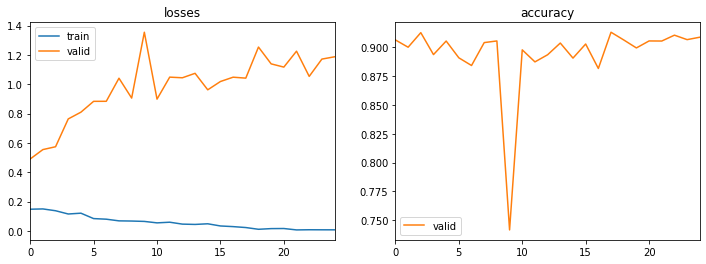

TensorCategory(0.9087)
0.9286539842381678
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     90989
           1       0.66      0.18      0.29      1006
           2       0.53      0.72      0.61       503
           3       0.52      0.70      0.60      2975
           4       0.93      0.89      0.91     72530
           5       0.69      0.41      0.52       264
           6       0.46      0.36      0.40      4840

    accuracy                           0.91    173107
   macro avg       0.67      0.61      0.61    173107
weighted avg       0.91      0.91      0.91    173107



===================== Fold 1 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.156704,0.503639,0.852351,08:33
1,0.130964,0.492473,0.868960,08:33
2,0.120530,0.594902,0.867336,08:34
3,0.094193,0.699330,0.813139,08:35
4,0.079059,0.607433,0.831803,08:42
5,0.071872,0.527363,0.889201,08:38
6,0.075039,0.617000,0.840116,08:37
7,0.072179,0.682118,0.845910,08:36
8,0.059953,0.744514,0.842652,08:37
9,0.066534,0.718300,0.855355,08:36


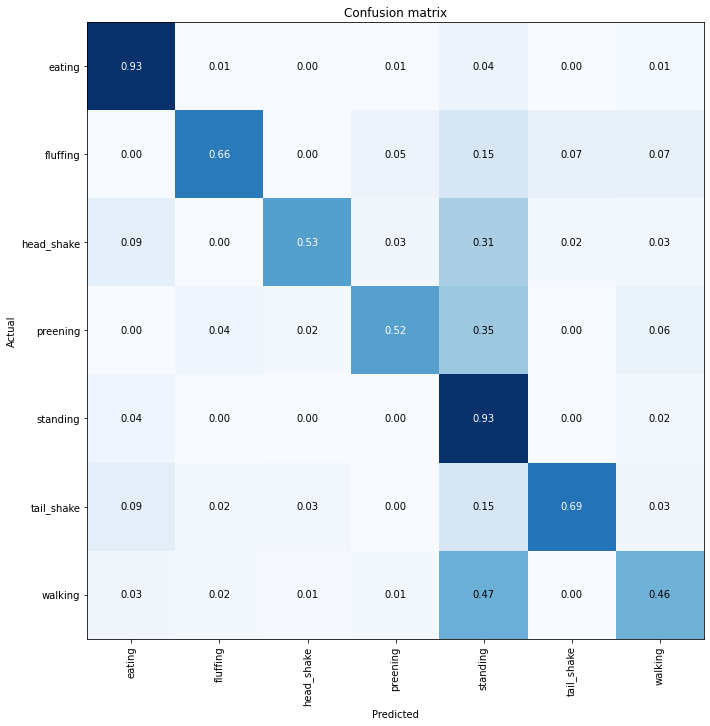

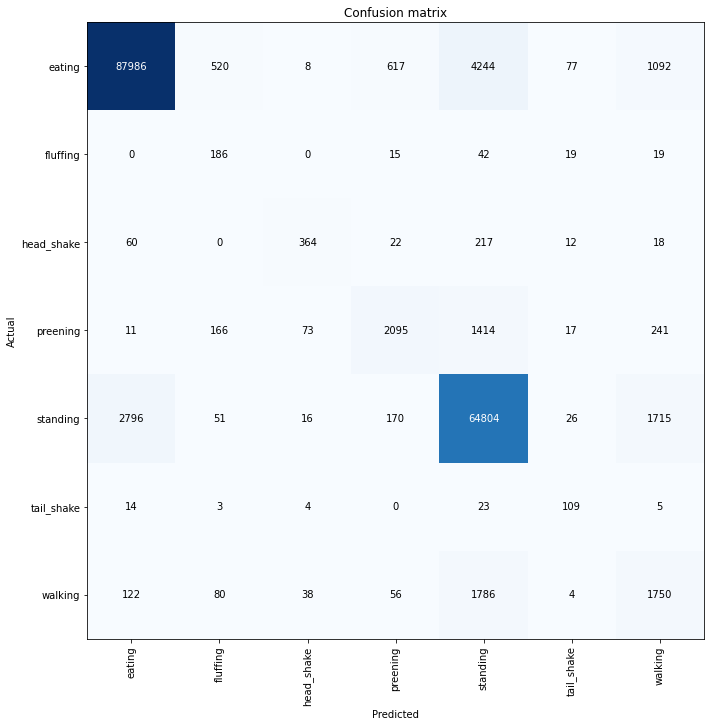

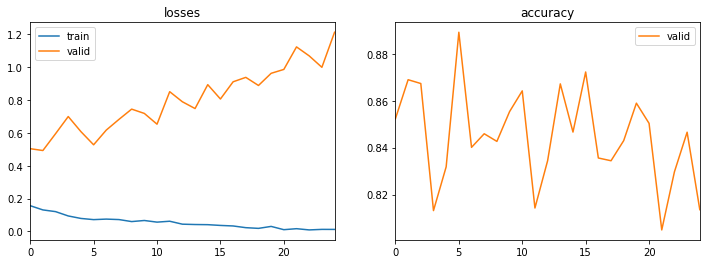

TensorCategory(0.8135)
0.9184246059955333
              precision    recall  f1-score   support

           0       0.83      0.96      0.89     67848
           1       0.78      0.14      0.24     16764
           2       0.65      0.73      0.69      1570
           3       0.72      0.78      0.75     19448
           4       0.86      0.91      0.88     60120
           5       0.51      0.66      0.58       999
           6       0.40      0.24      0.30      6358

    accuracy                           0.81    173107
   macro avg       0.68      0.63      0.62    173107
weighted avg       0.80      0.81      0.78    173107



===================== Fold 2 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.171662,0.793193,0.700051,08:37
1,0.123425,0.585221,0.843651,08:40
2,0.130111,1.328161,0.703996,08:41
3,0.106742,0.771652,0.768541,08:42
4,0.088262,1.053944,0.683454,08:40
5,0.073234,0.791815,0.790891,08:40
6,0.080662,0.770501,0.801717,08:46
7,0.059503,0.939035,0.738599,08:42
8,0.059097,1.129649,0.722598,08:42
9,0.053891,0.818078,0.829388,08:59


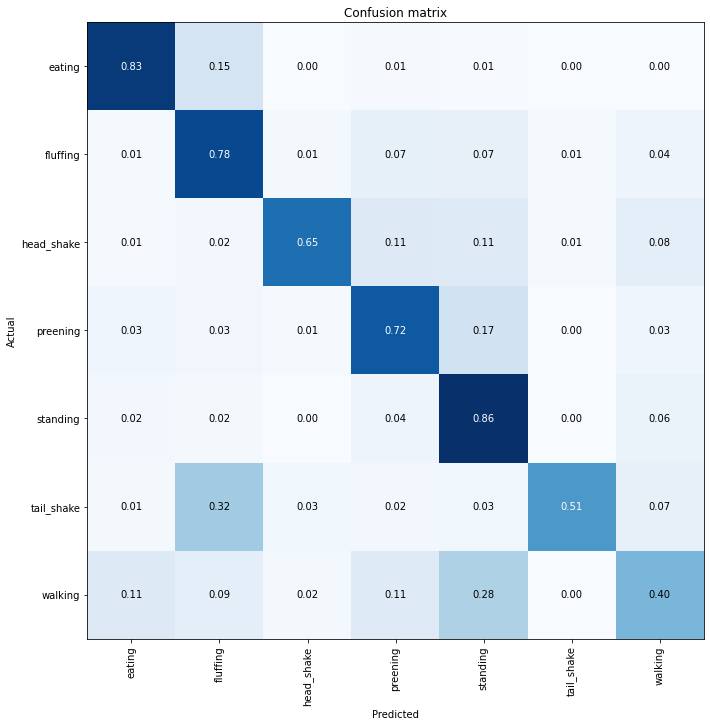

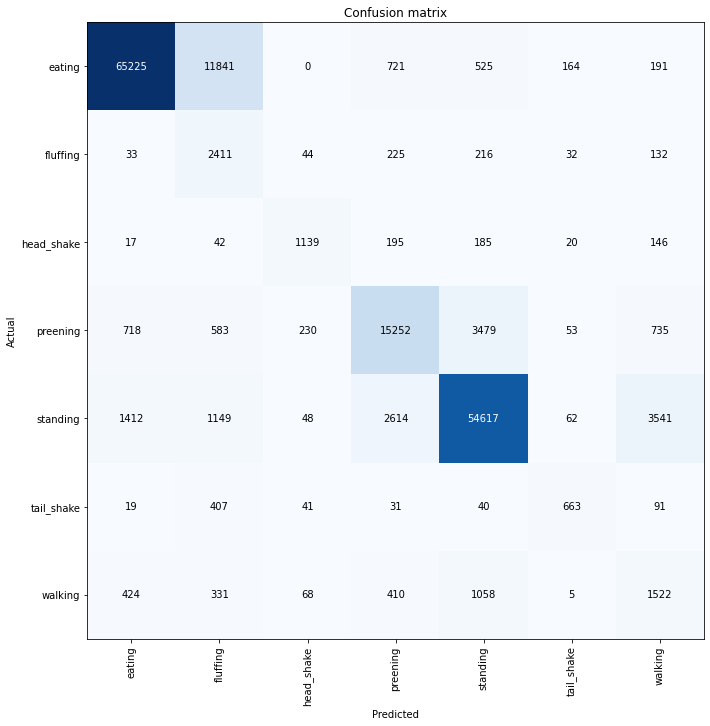

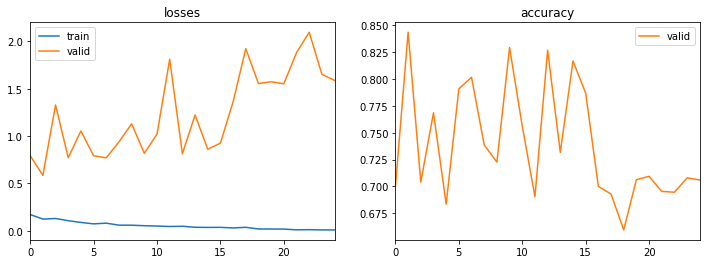

TensorCategory(0.7059)
0.8948349476387172
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     64357
           1       0.73      0.60      0.66      8691
           2       0.39      0.68      0.50      1801
           3       0.70      0.33      0.45     45138
           4       0.48      0.83      0.61     40717
           5       0.60      0.65      0.63      2509
           6       0.54      0.22      0.31      9893

    accuracy                           0.71    173106
   macro avg       0.63      0.61      0.59    173106
weighted avg       0.74      0.71      0.69    173106



===================== Fold 3 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.152499,0.357442,0.886284,10:46
1,0.137141,0.412811,0.878496,09:24
2,0.105088,0.417151,0.886162,08:50
3,0.094663,0.439049,0.892655,08:35
4,0.084834,0.425992,0.895677,08:47
5,0.086618,0.397598,0.902337,08:58
6,0.076524,0.410139,0.893811,09:07
7,0.063895,0.437094,0.899033,09:00
8,0.061404,0.443617,0.894492,09:06
9,0.049089,0.496796,0.889068,08:49


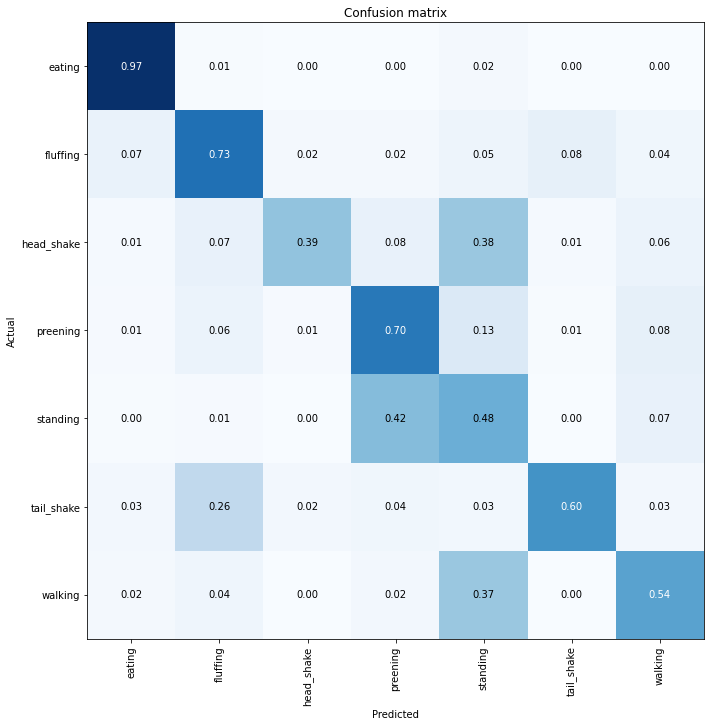

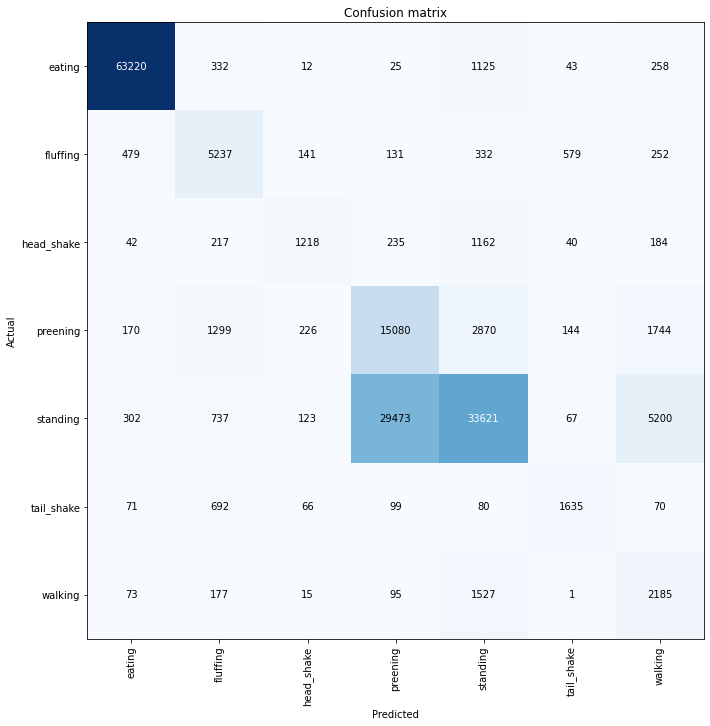

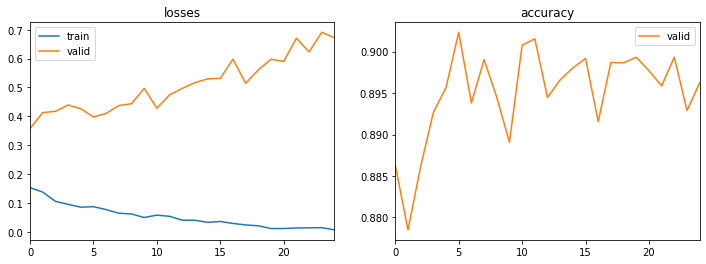

TensorCategory(0.8962)
0.9129857209662489
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     52570
           1       0.68      0.72      0.70      5107
           2       0.66      0.41      0.51      2674
           3       0.48      0.72      0.57      6242
           4       0.95      0.92      0.93     95742
           5       0.48      0.42      0.45       779
           6       0.59      0.60      0.60      9992

    accuracy                           0.90    173106
   macro avg       0.69      0.68      0.68    173106
weighted avg       0.90      0.90      0.90    173106



===================== Fold 4 ============================


KeyboardInterrupt: 

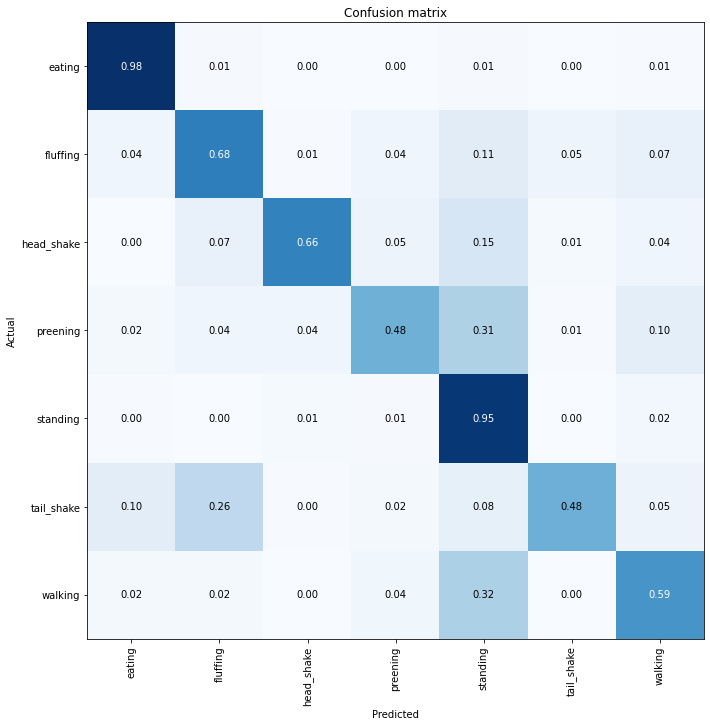

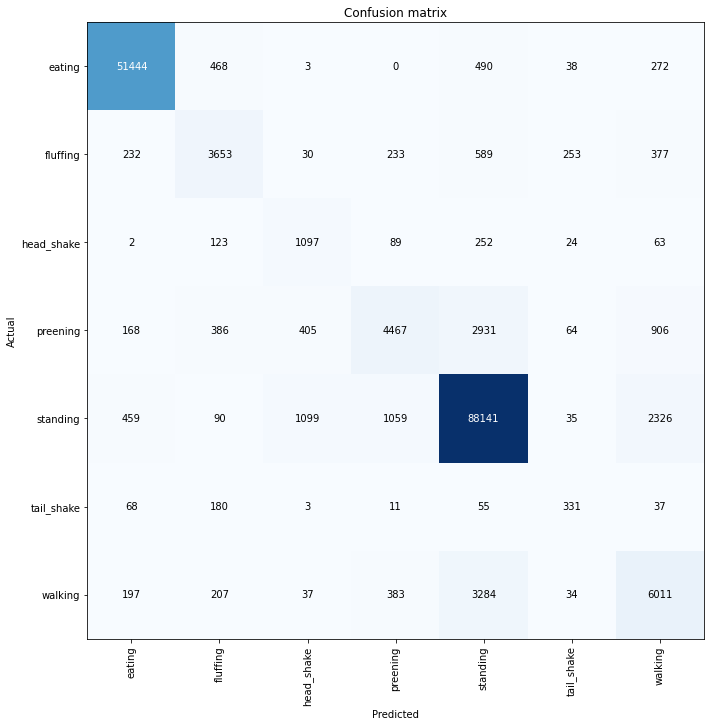

In [86]:
for i, s in enumerate(splits):
    print(f'===================== Fold {i} ============================')
    train_and_evaluate_it(X, y, s, 32, 0.001, 25)

# Other architectures

In [70]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits[4], inplace=True)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=128, batch_tfms=[TSStandardize()], num_workers=0)

## OmniScaleCNN

In [72]:
model = create_model(OmniScaleCNN, dls=dls)
learn = Learner(dls, model,  metrics=accuracy)

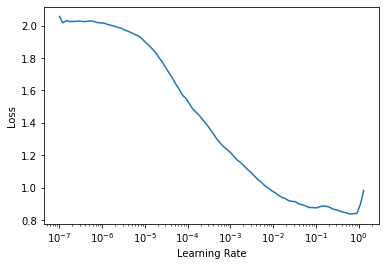

In [74]:
lr_min,lr_steep = learn.lr_find(suggestions=True)
print(f"Minimum/10: {lr_min}, steepest point: {lr_steep}")

In [76]:
learn.fit_one_cycle(2, lr_max=lr_steep)

epoch,train_loss,valid_loss,accuracy,time
0,0.175352,0.396479,0.878312,03:15
1,0.124809,0.381283,0.884279,03:12


In [77]:
dls = learn.dls
valid_dl = dls.valid
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)
cat_ac = (valid_targets == valid_preds).float().mean()
print(cat_ac)
print(roc_auc_score(valid_targets, valid_probas, multi_class='ovo', average='macro'))
print(classification_report(valid_preds, valid_targets))

TensorCategory(0.8843)
0.9202430993476572
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     64542
           1       0.61      0.88      0.72      8159
           2       0.07      0.22      0.11       521
           3       0.69      0.65      0.67      9448
           4       0.95      0.87      0.91     84374
           5       0.51      0.52      0.52      1713
           6       0.36      0.53      0.43      4349

    accuracy                           0.88    173106
   macro avg       0.59      0.66      0.62    173106
weighted avg       0.90      0.88      0.89    173106



## ResNet

Minimum/10: 0.10964782238006592, steepest point: 0.0014454397605732083


epoch,train_loss,valid_loss,accuracy,time
0,0.097466,0.370655,0.893869,02:40
1,0.030205,0.429562,0.906993,02:41


TensorCategory(0.9070)
0.9452712962803768
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     65882
           1       0.69      0.86      0.77      9470
           2       0.58      0.57      0.57      1607
           3       0.76      0.72      0.74      9382
           4       0.94      0.92      0.93     78474
           5       0.57      0.53      0.55      1881
           6       0.50      0.50      0.50      6410

    accuracy                           0.91    173106
   macro avg       0.72      0.73      0.72    173106
weighted avg       0.91      0.91      0.91    173106



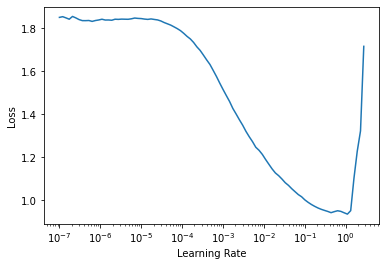

In [80]:
model = create_model(ResNet, dls=dls)
learn = Learner(dls, model,  metrics=accuracy)

lr_min,lr_steep = learn.lr_find(suggestions=True)
print(f"Minimum/10: {lr_min}, steepest point: {lr_steep}")
learn.fit_one_cycle(2, lr_max=lr_steep)
dls = learn.dls
valid_dl = dls.valid
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)
cat_ac = (valid_targets == valid_preds).float().mean()
print(cat_ac)
print(roc_auc_score(valid_targets, valid_probas, multi_class='ovo', average='macro'))
print(classification_report(valid_preds, valid_targets))

## RNN_FCN

Minimum/10: 0.012022644281387329, steepest point: 0.0014454397605732083


epoch,train_loss,valid_loss,accuracy,time
0,0.108284,0.420133,0.889796,01:43
1,0.046740,0.485253,0.898103,01:45


TensorCategory(0.8981)
0.9316069286005573
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     65548
           1       0.69      0.85      0.77      9584
           2       0.44      0.35      0.39      1977
           3       0.72      0.66      0.69      9598
           4       0.93      0.91      0.92     78533
           5       0.58      0.56      0.57      1796
           6       0.48      0.51      0.50      6070

    accuracy                           0.90    173106
   macro avg       0.69      0.69      0.69    173106
weighted avg       0.90      0.90      0.90    173106



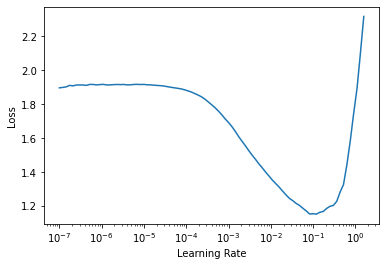

In [83]:
model = create_model(RNN_FCN, dls=dls)
learn = Learner(dls, model,  metrics=accuracy)

lr_min,lr_steep = learn.lr_find(suggestions=True)
print(f"Minimum/10: {lr_min}, steepest point: {lr_steep}")
learn.fit_one_cycle(2, lr_max=lr_steep)
dls = learn.dls
valid_dl = dls.valid
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)
cat_ac = (valid_targets == valid_preds).float().mean()
print(cat_ac)
print(roc_auc_score(valid_targets, valid_probas, multi_class='ovo', average='macro'))
print(classification_report(valid_preds, valid_targets))

Minimum/10: 0.07585775852203369, steepest point: 0.002511886414140463


epoch,train_loss,valid_loss,accuracy,time
0,0.105569,0.442134,0.890662,01:55
1,0.046293,0.488129,0.902591,01:55


TensorCategory(0.9026)
0.9294187927315146
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     66023
           1       0.71      0.88      0.79      9455
           2       0.43      0.37      0.40      1846
           3       0.71      0.73      0.72      8578
           4       0.94      0.91      0.93     79256
           5       0.53      0.54      0.53      1719
           6       0.48      0.50      0.49      6229

    accuracy                           0.90    173106
   macro avg       0.68      0.70      0.69    173106
weighted avg       0.91      0.90      0.90    173106



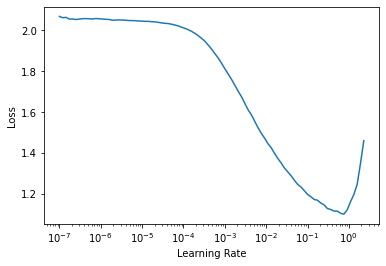

In [84]:
model = create_model(LSTM_FCN, dls=dls)
learn = Learner(dls, model,  metrics=accuracy)

lr_min,lr_steep = learn.lr_find(suggestions=True)
print(f"Minimum/10: {lr_min}, steepest point: {lr_steep}")
learn.fit_one_cycle(2, lr_max=lr_steep)
dls = learn.dls
valid_dl = dls.valid
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)
cat_ac = (valid_targets == valid_preds).float().mean()
print(cat_ac)
print(roc_auc_score(valid_targets, valid_probas, multi_class='ovo', average='macro'))
print(classification_report(valid_preds, valid_targets))